![img](./images/Mayo_Clinic.Header.webp)

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,\
    GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,\
    FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,\
    GradientBoostingClassifier, AdaBoostClassifier,\
    BaggingClassifier, ExtraTreesClassifier,\
    VotingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve,confusion_matrix

import xgboost

import pickle

from imblearn.pipeline import Pipeline as ImPipeline

#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
from sklearn.metrics import roc_curve
from numpy import sqrt, argmax

import model2
from model2 import *

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

The 'import model' line is for a class ModelWithCV. 

### Problem Description

The Mayo Clinic has tasked us with predicting how likely individuals are to receive the seasonal flu vaccine. 
We will concentrate on:
- Predicting who will get the seasonal vaccine?
- The most significant features in determining whether or not an individual will get vaccinated? 
- How can we get more people to get vaccinated?

### Data

The data was provided by DrivenData as a part of their competition. Details about the competition and getting the data can be found https://www.drivendata.org/competitions/66/flu-shot-learning/

The data was provided in two separate files, which were combined for cleaning splitting again later. 

In [3]:
training_set_features = pd.read_csv('./Data/training_set_features.csv')
training_set_labels = pd.read_csv('./Data/training_set_labels.csv')
complete_data = pd.merge(training_set_features, training_set_labels, on='respondent_id')

In [4]:
complete_data.isna().sum().sort_values(ascending=False).head(10)

employment_occupation    13470
employment_industry      13330
health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

There are a considerable number of NA values in the dataset.

If the employment_status column has a value of Not in Labor Force, then columns employment_industry and employment_occupation will have NA's. 

Values in columns employment_industry and employment_occupation are represented as short random character strings. 

We will be filling NA's in employment_occupation and employment_industry associated with "Not in Labor Force" with because they would otherwise be imputed as the most frequent occupation or industry.

Filling Unemployed with "Not in Labor Force".

In [5]:
complete_data['employment_status'].replace("Unemployed", "Not in Labor Force", inplace=True)
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_industry'] = "Not in Labor Force"
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "Not in Labor Force"

In [6]:
complete_data.isna().sum().sort_values(ascending=False).head(10)

health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_occupation     1786
employment_industry       1646
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

In [7]:
complete_data['health_insurance'].isna().sum()

12274

In [8]:
complete_data['health_insurance'].fillna('Unknown', inplace=True)
complete_data['health_insurance'].replace(0.0,'0', inplace=True)
complete_data['health_insurance'].replace(1.0,'1', inplace=True)

With the substantial number of NA's in Health Insurance we have decided to create a new category of "Unknowns". Replaced float values of 1.0 and 0.0 with string values. 

#### Target Distribution

In [9]:
complete_data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

### Split

Here we separated out our target variable 'seasonal_vaccine' and dropped 'respondent_id' and 'h1n1_vaccine'.

The 'values.ravel()' method reshapes y_train into a 1-D array.

In [10]:
X = complete_data.drop(['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis=1)
y = complete_data.filter(['seasonal_vaccine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train = y_train.values.ravel()

### Pipelines for Column Transformer

All columns are in a categorical format, however, some are scales and may better be represented as numeric columns.

Numeric columns include h1n1_concern, h1n1_knowledge, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc, opinion_seas_vacc_effective, opinion_seas_risk, and opinion_seas_sick_from_vacc.

In [11]:
num_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',\
            'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',\
            'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
cat_cols = X.columns.drop(num_cols)

In [12]:
X[num_cols].describe()

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
count,26615.000000,26591.000000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000
mean,1.618486,1.262532,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112
std,0.910311,0.618149,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000
50%,2.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000
75%,2.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000
max,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [13]:
X[num_cols].median()

h1n1_concern                   2.0
h1n1_knowledge                 1.0
opinion_h1n1_vacc_effective    4.0
opinion_h1n1_risk              2.0
opinion_h1n1_sick_from_vacc    2.0
opinion_seas_vacc_effective    4.0
opinion_seas_risk              2.0
opinion_seas_sick_from_vacc    2.0
dtype: float64

Because there are some missing values in the numeric columns, it is important determine the best measure of central tendency to replace these values. Because the values are scaler in nature we have decided to use the 'median' of each column to fill in these values.  

For categorical variables, the most frequent value for each column will be used to fill in the missing values.

In [14]:
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')) ])

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy='median')),
                              ('ss', StandardScaler()) ])

In [15]:
ct = ColumnTransformer(transformers = [
    ('subpipe_cat', subpipe_cat, cat_cols),
    ('subpipe_num', subpipe_num, num_cols)
])

### Models

Now that our Column Transformer pipeline has been created we can start running models.

#### Dummy Classifier

In [16]:
dummy_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(random_state=42))
])

In [17]:
dummy_model_pipe.fit(X_train, y_train);

In [18]:
dummy_model_pipe.score(X_train, y_train)

0.5310456603140893

In [19]:
dummy_pipe = ModelWithCV(dummy_model_pipe, model_name='dummy_pipe', X=X_train, y=y_train) #2s

In [20]:
dummy_pipe.print_cv_summary() #6s

CV Results for `dummy_pipe` model:
            0.53105 ± 0.00015 accuracy
            recall_score: 0.0
            precision_score: 0.46895434857961904
            f1_score: 0.0    
        


The 'print_cv_summary' function comes from the ModelWithCV class where the model runs a 10 fold cross validation to return accuracy, recall, precision, and f1 score.

Our dummy classifier predicts the most common value for the target value. It's accuracy is at about 53%.

#### Random Forest

In [21]:
import pickle
with open('forest.sav', 'rb') as f:
    forest = pickle.load(f)

In [22]:
forest.print_cv_summary()

CV Results for `forest_pipe` model:
            0.77153 ± 0.01219 accuracy
            recall_score: 0.7391263692604574
            precision_score: 0.8263930425720363
            f1_score: 0.7521140408449998    
        


##### Random Forest  Tuned

Our Grid Search determined the optimal parameters for Random Forest was max_features= 'sqrt' and n_estimators= 1000.

In [23]:
import pickle
with open('tuned_forest.sav', 'rb') as f:
    tforest = pickle.load(f)

In [24]:
tforest.print_cv_summary() 

CV Results for `tforest_pipe` model:
            0.77706 ± 0.01164 accuracy
            recall_score: 0.7499721891140246
            precision_score: 0.8336055852918713
            f1_score: 0.759324132932402    
        


#### Extra Trees Classifier

In [25]:
import pickle
with open('etc.sav', 'rb') as f:
    etc = pickle.load(f)

In [26]:
etc.print_cv_summary() 

CV Results for `etc_pipe` model:
            0.77058 ± 0.01184 accuracy
            recall_score: 0.733285941313355
            precision_score: 0.8226913437164194
            f1_score: 0.7498575863366292    
        


#####  Extra Trees Tuned

Our Grid Search determined the optimal parameters for Gradient Booster was max_depth = 50 and n_estimators = 500.

In [27]:
import pickle
with open('tuned_etc.sav', 'rb') as f:
    tetc = pickle.load(f)

In [28]:
tetc.print_cv_summary() 

CV Results for `tetc_pipe` model:
            0.77399 ± 0.01175 accuracy
            recall_score: 0.740079743458766
            precision_score: 0.8302410092727717
            f1_score: 0.7543782442015724    
        


### Ensembled

The tuned Random Forest model and tuned Extra Trees model were entered into a Voting Classifier. Below the results of that Classifier were imported as a pickle to save time.

In [29]:
with open('avg2_model.sav', 'rb') as f:
    avg2_model = pickle.load(f)

In [30]:
avg2_model.print_cv_summary()

CV Results for `avg2_pipe` model:
            0.77718 ± 0.01159 accuracy
            recall_score: 0.7463972132357114
            precision_score: 0.8337415272006232
            f1_score: 0.7585331782501775    
        


### Feature Importance

In [31]:
avg2_model.model.fit(X_train, y_train);

In [32]:
ohe_col_names = avg2_model.model.named_steps['ct'].named_transformers_['subpipe_cat']['ohe'].get_feature_names_out()

ohe_cat_cols = ohe_col_names.tolist()

In [33]:
post_ct_cols = ohe_cat_cols + num_cols

In [34]:
X_post = pd.DataFrame(avg2_model.model.named_steps['ct'].fit_transform(X_train, y_train), columns=post_ct_cols)

In [35]:
for alg in avg2_model.model.named_steps['avg2'].named_estimators:
    clf = avg2_model.model.named_steps['avg2'].named_estimators[alg]
    feat_imp = clf.fit(X_post, y_train).feature_importances_ #22s

In [36]:
A = pd.DataFrame()
A['Features'] = post_ct_cols
A['Feature_importance'] = feat_imp
top_ten_feat = A.sort_values('Feature_importance', ascending=False).head(10)

In [37]:
top_ten_feat.Features = [row.strip().lower().replace('_',' ') for row in top_ten_feat.Features]

In [38]:
top_ten_feat

,Features,Feature_importance
97,opinion seas risk,0.073407
8,x8 1.0,0.071190
96,opinion seas vacc effective,0.064587
17,x13 65+ years,0.038439
94,opinion h1n1 risk,0.029668
93,opinion h1n1 vacc effective,0.026548
98,opinion seas sick from vacc,0.023892
91,h1n1 concern,0.023393
95,opinion h1n1 sick from vacc,0.021370
92,h1n1 knowledge,0.020897


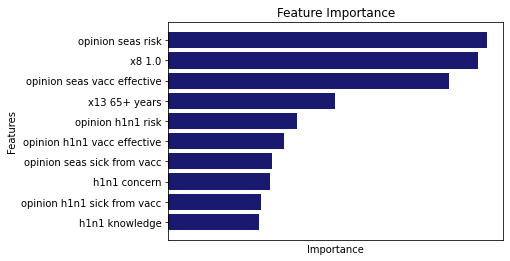

In [39]:
fig, ax = plt.subplots()
ax.barh(y= top_ten_feat.Features, width= top_ten_feat['Feature_importance'], color='midnightblue')
ax.set_title('Feature Importance')
ax.set_ylabel('Features')
ax.set_xlabel('Importance')
plt.xticks([])
ax.invert_yaxis()
plt.savefig('./images/Feature_Importance.jpeg', bbox_inches = 'tight');

The top 3 most important features in determining whether a person was to get vaccinated are 
- A person's opinion on the risk of the seasonal flu 
- x8 1.0 which is Doctor Recommended
- an opinion on seasonal vaccine effectiveness

### Final Model

In [40]:
final_model = avg2_model.model

In [41]:
final_model.fit(X_train, y_train); 

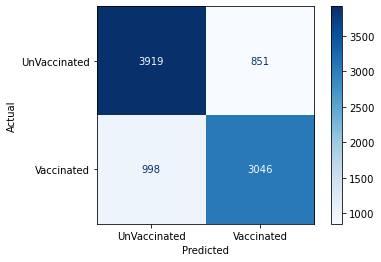

In [42]:
fm_cm = plot_confusion_matrix(final_model, X_test, y_test, cmap="Blues",\
                              display_labels=['UnVaccinated','Vaccinated'])
fm_cm.ax_.set(xlabel='Predicted', ylabel='Actual')

plt.savefig('./images/Confusion.jpeg', bbox_inches = 'tight');

In [43]:
y_hat = final_model.predict(X_test) 

In [44]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.75 

Our final model's precision on the test set is 0.78 

Our final model's f1-score on the test is 0.77.



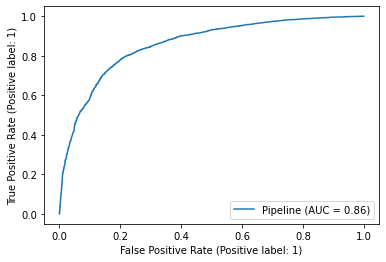

In [45]:
fm1_roc_curve = plot_roc_curve(final_model, X_test, y_test)
plt.savefig('./images/ROC_Curve.jpeg', bbox_inches = 'tight');

In [46]:
y_hat = final_model.predict_proba(X_test)[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.471400, G-Mean=0.791


In [47]:
y_hat = (final_model.predict_proba(X_test)[:,1] >= thresholds[ix]).astype(bool) 

In [48]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.79 

Our final model's precision on the test set is 0.76 

Our final model's f1-score on the test is 0.78.



In [49]:
cm = confusion_matrix(y_test, y_hat)

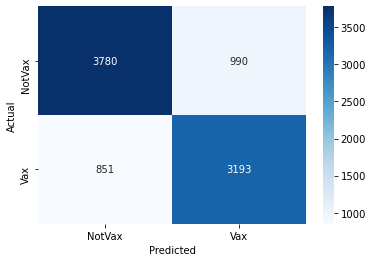

In [50]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels= ['NotVax', 'Vax'],
            yticklabels= ['NotVax', 'Vax'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('./images/Confusion2.jpeg', bbox_inches = 'tight');

In [51]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

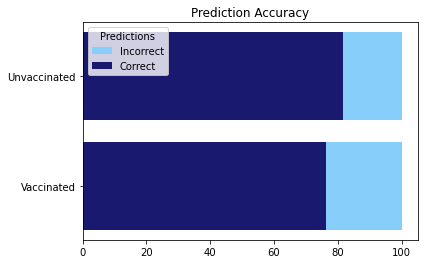

In [52]:
b2 = plt.barh(['Vaccinated', 'Unvaccinated'], 
              [100*(TP/ (TP+FP)), 100*(TN/ (TN+FN))],
              color="midnightblue")

b1 = plt.barh(['Vaccinated', 'Unvaccinated'], 
              [100*(FP/ (TP+FP)),100*(FN/ (TN+FN))], 
              left=[100*(3193/ (TP+FP)), 100*(TN/ (TN+FN))], 
              color="lightskyblue")

plt.legend([b1, b2], ["Incorrect", "Correct"], 
           title="Predictions", loc="best")
plt.title('Prediction Accuracy')

plt.savefig('./images/Prediction_Accuracy.jpeg', bbox_inches = 'tight')
plt.show();

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

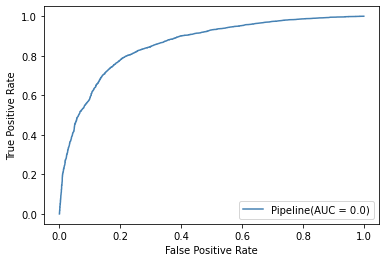

<Figure size 432x288 with 0 Axes>

In [54]:
#from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
final_model.fit_transform(X_train, y_train)
# predict probabilities
lr_probs = final_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = round((roc_auc_score(y_test, lr_probs)), -2)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, label=f'Pipeline(AUC = {lr_auc})', color='steelblue')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()
plt.savefig('./images/ROC_Curve2.jpeg', bbox_inches = 'tight');

Customizing our classification threshold here doesn't improve our model significantly, however, it could prove essential in a data set where the target variable is more imbalanced.

### Next Steps

With more time we could run and tune more models. More and better models could improve our models performance.